# The basics of Bayesian optimization

Many real-world problems involve optimization of functions which are difficult, or costly, to evaluate. For instance, in deep learning, finding the optimal hyperparameters and architecture of a neural network is a cumbersome process that should ideally be automated with as little fuction evaluations (i.e. training the networks) as possible.

For problems like these, Bayesian optimization (BO) offers a unifying framework where the function to evaluate is approximated using a surrogate model, for instance a Gaussian process. In this notebook, we introduce the basics of BO.

We load some libraries first.

In [32]:
suppressMessages({    
    library(tidyverse)    
    library(colorspace)    
    library(rstan)
    library(bayesplot)
})

set.seed(23)

In [227]:
scatterplot <- function(
    x.true, y.true, f_star=NULL, f_star_var=NULL, data=NULL) {
    df <- data.frame(x=x.true, y=y.true)
   
    g <- ggplot() +
        geom_point(data=df, aes(x, y, color="lightgrey"), pch="x") +
        theme(axis.line.x = element_line(color="black", size = .25),
              axis.line.y = element_line(color="black", size = .25))

    if (!is.null(f_star) && !is.null(f_star_var)) {
        df_star <- data.frame(
            x=x.true,
            y=f_star, 
            lower=f_star - sqrt(f_star_var), 
            upper=f_star + sqrt(f_star_var))
        g <- g + 
            geom_ribbon(data=df_star, aes(x, ymin = lower, ymax = upper, fill="#DCBCBC")) +             
            geom_line(data=df_star, aes(x, y, color="darkred"))
    }
    if (!is.null(data)) {
        g <- g + geom_point(data=data, aes(x, y, color="darkred")) 
    }
    
    g + scale_color_manual(
            breaks = c("lightgrey", "darkred", "black"), 
            labels = c("Function to optimize", "Posterior", "Acquisition function"),
            values = c("lightgrey", "darkred", "black")
        ) +
        scale_fill_manual(
            breaks = c("lightgrey", "darkred", "#DCBCBC"),
            values = c("lightgrey", "darkred", "#DCBCBC")
        ) +
    labs(color = "Legend") +
    guides(fill=FALSE)
}

Usually the function to maximize is difficult/infeasible to query and the number of functions evaluations and we want to minimize the number as much as possible. In this example, we demonstration BO on the example function below.

In [3]:
f <- function(x) cos(4 * x) + exp(-(x ** 2) / 2)

Without loss of generality, we constrain the optimization on a set of $n$ points in the interval $x \in [-5, 5]$, such that we don't need to write to much boilerplate code.

In [4]:
n <- 1000

x.init = seq(-5, 5, length.out = n)
y.init = f(x.init)

Below is the function to optimize:

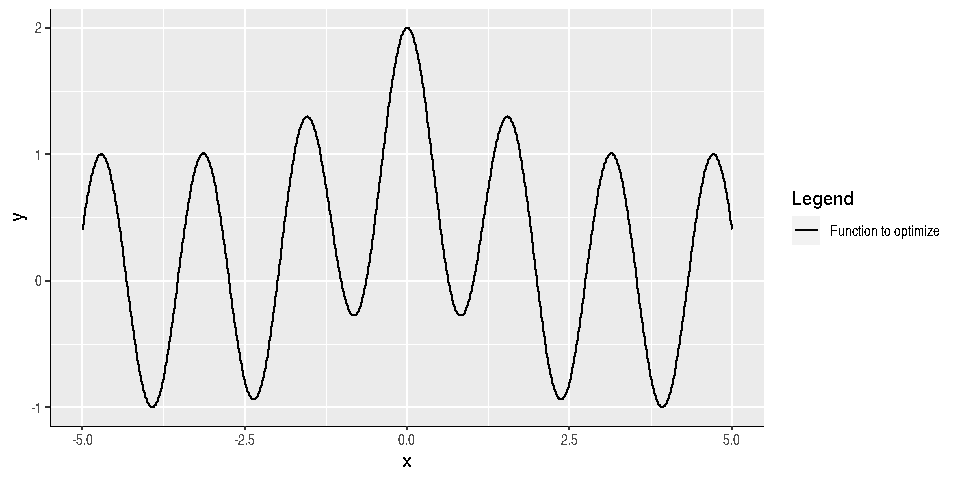

In [33]:
scatterplot(x.init, y.init)

To optimize this function, we define functions to fit a surrogate model and make a predict using the model fit. We use Stan to implement the surrogate model for which we use a Gaussian process.

In [36]:
surrogate.model.file <- "_models/bo-surrogate.stan"
cat(readLines(surrogate.model.file), sep="\n")

functions {
  vector gp_pred_rng(real[] x_star,
                     vector y, real[] x,
                     real alpha, real rho, real sigma) {
 	real delta = 1e-10;
    int N = size(y);
    int N_star = size(x_star);
    
    vector[N_star] f2;
    {
      matrix[N, N] K =  cov_exp_quad(x1, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N));
      matrix[N, N] L_K = cholesky_decompose(K);

      vector[N] L_K_div_y1 = mdivide_left_tri_low(L_K, y1);
      vector[N] K_div_y1 = mdivide_right_tri_low(L_K_div_y1', L_K)';
      
      matrix[N, N_star] k_x1_x2 = cov_exp_quad(x1, x2, alpha, rho);
      vector[N_star] f2_mu = (k_x1_x2' * K_div_y1);
     
      matrix[N, N_star] v_pred = mdivide_left_tri_low(L_K, k_x1_x2);
      matrix[N_star, N_star] cov_f2 =   cov_exp_quad(x2, alpha, rho) - v_pred' * v_pred
                              + diag_matrix(rep_vector(delta, N_star));

      f2 = multi_normal_rng(f2_mu, cov_f2);
    }

    return f2;
  }
}

data {
	i

In [60]:
gp <- stan_model(file = surrogate.model.file)

In [162]:
predict.gp <- function(gp, x, y, x.star) {
    dat <- list(
        N=length(x),
        x=as.vector(x),
        y=as.vector(y),
        N_star=length(x.star),
        x_star=x.star,
        rho=1,
        alpha=1,
        sigma=1
    )
    
    pred <- rstan::sampling(gp, dat, chains=1, algorithm="Fixed_param", iter=1)

    ext <- rstan::extract(pred)
    f.star <- as.vector(ext$f_star)
    f.star_var <- as.vector(ext$f_star_cov)
    
    
    list(f.star, f_star_var)
}

As acquisition function we use the upper confidence bound.

In [147]:
acquisition.function <- function(gp, x.d, y.d, x.init, conf) {
    preds <- predict.gp(gp, x.d, y.d, x.init)
    f.star <- preds[[1]]
    f.star_var <- preds[[2]]
    ucb <- f.star + conf * sqrt(f.star_var)
    ucb
}

Finally, we define a function that proposes the next point to evaluate.

In [148]:
acquire <- function(x.d, y.d, x.init, conf=2.0) {
    preds <- predict.gp(gp, x.d, y.d, x.init)
    f.hat <- preds[[1]]
    f.star_var <- preds[[2]]

    ucb <- acquisition.function(gp, x.d, y.d, x.init, conf)
    x.next <- x.init[which.max(ucb)]
    list(x.next=x.next, ucb=ucb, f.hat=f.hat, f.star_var=f.star_var)
}    

We start with a random point on the interval defined above and query it against the function that we want to evaluate

In [245]:
set.seed(23)

x.d <- runif(2, -5, 5)
y.d <- f(x.d)

Then we train the surrogate model, and use the aquisition function to propose a new point.

In [246]:
iter <- acquire(x.d, y.d, x.init)
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.hat
f.star.var <- iter$f.star_var


SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021996 seconds (Sampling)
Chain 1:                0.021996 seconds (Total)
Chain 1: 

SAMPLING FOR MODEL 'bo-surrogate' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.021744 seconds (Sampling)
Chain 1:                0.021744 seconds (Total)
Chain 1: 


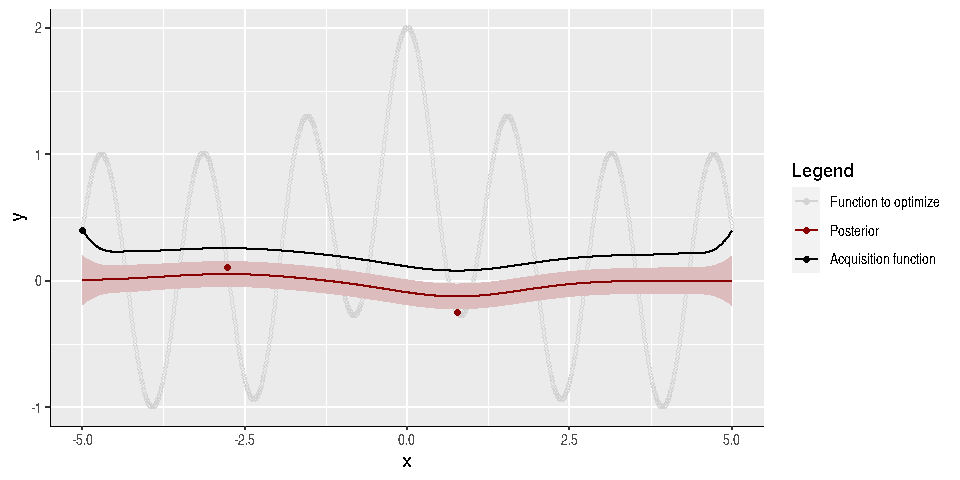

In [247]:
g <- scatterplot(x.init, y.init, f.star, f.star.var, data=data.frame(x=x.d, y=y.d))
g + geom_line(data=data.frame(x=x.init, y=ucb), aes(x, y, color="black")) +
    geom_point(data=data.frame(x=x.n, y=max(ucb)), aes(x, y))

In [226]:
y_n = f(x_n)

x_d = np.vstack([x_d, x_n])
y_d = np.vstack([y_d, y_n])
x_n, acqs, y_hat, y_hat_var = acquire(x_d, y_d, x_init)

fig, ax = plot(x_init, y_init, y_hat, y_hat_var, xy_n=[x_d, y_d])
plt.plot(x_init, acqs, color="darkblue", label="Acquisition function")
plt.scatter(
    x_n, np.max(acqs), color="darkblue", label="Maximum of acquisition function"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()